## Multi Layer Perceptron

MLP with configurable number of (dense) hidden layers and final softmax layer 

The propagation and backpropagation is implemented "from scratch" using numpy

For debbuging purposes you may want to choose MNIST light. Set $mnist = 0$ in cell [2]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds 
from sklearn import model_selection as ms

#get local download folder where data is stored
#you may change this in the call fetch_openml() below
data_h = ds.get_data_home()
print(data_h)

C:\Users\tazahn\scikit_learn_data


In [2]:
#choose 0 to work with mnist light (simpler for debugging) 
mnist_flag = 1

if mnist_flag == 1:
    # the first time this will download the data from the internet and put to a local folder 
    mnist = ds.fetch_openml(name='mnist_784')

    # digit is a "bunch" i.e. similar to a dictionary
    print(type(mnist))
    # show the keys of digit
    print(mnist.keys())
    # get data i.e. the image (x) and labels (y)
    x = mnist['data']
    # as compare to the in class activity we convert the labels here to int
    y = np.array(mnist['target'], dtype='int')
    #set image width
    img_width = 28
else:
    mnist_light = ds.load_digits()
    # digit is a "bunch" i.e. similar to a dictionary
    print(type(mnist_light))
    # show the keys of digit
    print(mnist_light.keys())
    # get data i.e. the image (x) and labels (y)
    x = mnist_light['data']
    y = mnist_light.target
    #set image width
    img_width = 8
    
# get the respective shape
print("x shape:", x.shape)
print("y shape:", y.shape)

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
x shape: (70000, 784)
y shape: (70000,)


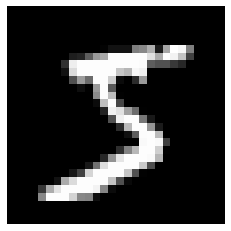

In [3]:
def plot_img(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    
    
img = x[0,:].reshape((img_width,img_width))
plot_img(img)

In [4]:
def plot_tiles(x_array, rows, cols = -1, digit_size = 28, fig_size = [10,10]):
    """
    plot list of mnist images as single image

    Arguments:
    x_array -- array of mnist images (being organised as ROWS!)
    rows/cols -- an image of rows x cols - mnist images is created (if x_array is smaller zeros ared padded)
    digit_size -- width (= height) of one single digit (= 8 for MNIST light, = 28 for MINIST)
    fig_size -- size of full image created (default [10,10])
    """
    #use rows = cols as default
    if cols < 0:
        cols = rows
        
    if x_array.shape[0] < rows*cols:
        cols = int(x_array.shape[0]/rows)
        remain = np.mod(x_array.shape[0], rows)
        if 0 < remain:
            cols += 1
            x_array = np.append(x_array, np.zeros((rows-remain, x_array.shape[1])), 0)    
        
    img = x_array[0:rows,:].reshape(rows*digit_size,digit_size)
    for i0 in range(1,cols):
        #the reshape operator in the append call takes num of digit_size x digit_size images and 
        #puts them in a single column; append then does the rest
        img = np.append(img, x_array[i0*rows:(i0+1)*rows,:].reshape(rows*digit_size,digit_size),1)

    fig = plt.figure(figsize = fig_size)
    ax = fig.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()

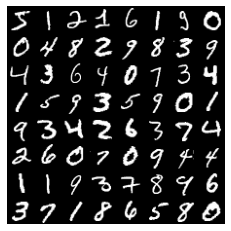

In [5]:
#append rows x cols tiles of digits
rows = 8
cols = 8
#figure size can be set
fig_size = [4,4]

plot_tiles(x, rows, cols, img_width, fig_size)

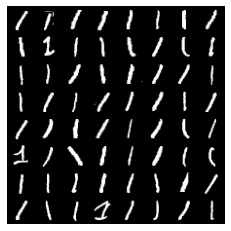

In [6]:
#choose a given digit 0..9
digit  = 1

plot_tiles(x[y == digit,:], rows, cols, img_width, fig_size)

In [7]:
#select training and test set (random_state sets the seed for reproducible results)

from sklearn import model_selection as ms

#define train and test split
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, 
                                     test_size=0.15, random_state=1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(59500, 784) (10500, 784) (59500,) (10500,)


In [8]:
#perform normalisation

xmax, xmin = np.max(x_train), np.min(x_train)
x_train = 2*(x_train - xmin) / (xmax - xmin) - 1
x_test = 2*(x_test - xmin) / (xmax - xmin) - 1

In [9]:
class MiniBatches:
    """
    obtains x- and y-data in the constructor and returns a sample of batch_size with each call to next()
    """
    def __init__(self, x, y, batch_size):
        """
        constructor

        Arguments:
        x/y -- data
        batch_size -- size of batch (0 means one single batch)
        """
        self.x = x
        self.y = y
        m = x.shape[0]
        self.indices = np.arange(m)
        self.n = x.shape[1]
        
        if not batch_size:
            self.batch_size = m
            self.mb = 1
        else:
            self.batch_size = batch_size        
            self.mb = int(m / self.batch_size)    
            np.random.shuffle(self.indices)
        
        self.ib = 0

    def number_of_batches(self):
        return self.mb

    def next(self):
        it = self.indices[self.ib * self.batch_size:(self.ib + 1) * self.batch_size]
        x_batch = self.x[it, :]
        y_batch = self.y[it]
        self.ib += 1

        return {'x_batch': x_batch, 'y_batch': y_batch}


### DenseLayer
Implementation of class for dense layer of MLP with sigmoid activation function. This class is used by the class MultiLayerPerceptron below.

In [52]:
class DenseLayer:
    """
    constructs a dense layer with sigmoid activation function for a MLP
    """
    def __init__(self, num_in, num_out):
        """
        constructor

        Arguments:
        num_in -- number of inputs (i.e. of neurons from previous layer)
        num_out -- number of outputs (i.e. of neurons in this layer) 
        """
        
        self.num_in = num_in
        self.num_out = num_out
        
        # initialize weights and bias (zero or random)
        self.initialise_weights()
    
    
    def initialise_weights(self):
        """
        initialise weights
        """
        # initialize weights and bias 
        random_std_W = np.sqrt(2.0/(self.num_in + self.num_out)) # suited for sigmoid activation function     
        random_std_B = np.sqrt(1.0/self.num_out)
        self.W = random_std_W * np.random.randn(self.num_in, self.num_out)        
        self.B = random_std_B * np.random.randn(1, self.num_out)
        
        
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    
    def d_sigmoid(self, z):
        """
        calculates the derivative of the sigmoid function
        """
        return self.sigmoid(z)*(1 - self.sigmoid(z))
        
        
    def propagate(self, a_in):
        """
        calculates the activation a_out based on activation from previous layer a_in
        """    
        self.num_samples = a_in.shape[0] #may change in different steps
        self.a_in = a_in # required for back_prop
        
        ### START YOUR CODE ###
        
        #calculate logits (for back_prop)
        self.Z = np.zeros((a_in.shape[0],self.W.shape[1]))
        a_out = self.Z
        
        ### END YOUR CODE ###         
        
        return a_out
            
     
    def back_propagate(self, dL_da_out):
        """
        calculates the backpropagation results based on the gradient of cost wrt to output activations
        this function must be performed AFTER the corresponding propagte step
        """    
        ### START YOUR CODE ###
        
        dL_dz = np.zeros(dL_da_out.shape)
        dL_da_in = np.zeros((dL_da_out.shape[0], self.W.shape[0]))
        self.dL_dW = np.zeros(self.W.shape)
        self.dL_dB = np.zeros(self.B.shape)
        
        ### END YOUR CODE ###    
        
        return dL_da_in
        
        
    def gradient_descend(self, alpha):
        """
        does the gradient descend based on results from last back_prop step with learning rate alpha
        """
        self.W -= alpha * self.dL_dW
        self.B -= alpha * self.dL_dB
        

### SoftmaxLayer
Implementation of class for softmax layer of MultiLayerPerceptron below. This class is used by the class MLP

In [53]:
class SoftmaxLayer:
    """
    constructs a sofmax layer for output of a MLP
    """
    def __init__(self, num_in, num_out):
        """
        constructor

        Arguments:
        num_in -- number of inputs from previous layer
        num_out -- number of neurons i.e. if outputs
        """
        
        self.num_in = num_in
        self.num_out = num_out
        
        # initialize weights and bias (zero or random)
        self.initialise_weights()
    
    
    def initialise_weights(self):
        """
        initialise weights
        """
        # initialize weights and bias 
        random_std_W = np.sqrt(2.0/(self.num_in + self.num_out)) # suited for sigmoid activation function     
        random_std_B = np.sqrt(1.0/self.num_out)
        self.W = random_std_W * np.random.randn(self.num_in, self.num_out)        
        self.B = random_std_B * np.random.randn(1, self.num_out)
        
        
    def propagate(self, a_in):
        """
        calculates the activation a_out based on activation from previous layer a_in
        """    
        self.num_samples = a_in.shape[0] #may change in different steps
        self.a_in = a_in # required for back_prop
        
        ### START YOUR CODE ###
        
        #calculate logits (for back_prop)
        self.Z = np.zeros((a_in.shape[0],self.W.shape[1]))
        self.y_pred = self.Z
        
        ### END YOUR CODE ###       
        
        return self.y_pred
    
    
    def one_hot(self, y):
        """
        construct onehot vector from set of labels
        """
        m = y.shape[0]
        one_hot = np.zeros((m, self.num_out), dtype=float)
        one_hot[np.arange(m), y] = 1

        return one_hot
            
     
    def back_propagate(self, y):
        """
        calculates the backpropagation results based on expected output y
        this function must be performed AFTER the corresponding propagte step
        """    
        ### START YOUR CODE ###
        
        dL_dz = np.zeros(self.y_pred.shape)
        dL_da_in = np.zeros((self.y_pred.shape[0], self.W.shape[0]))
        self.dL_dW = np.zeros(self.W.shape)
        self.dL_dB = np.zeros(self.B.shape)
        
        ### END YOUR CODE ###       
        
        return dL_da_in
        
        
    def gradient_descend(self, alpha):
        """
        does the gradient descend based on results from last back_prop step with learning rate alpha
        """
        self.W -= alpha * self.dL_dW
        self.B -= alpha * self.dL_dB
        

### Class MultiLayerPerceptron

This class constructs a full MLP based on the list of layers given in constructor. The hidden layers are all dense layers with sigmoid activation function the output layer is of softmax type.

The method $optimise()$ does the training. It receives the training and validation data as dictionary, the number of epochs, the learning rate and the batch size. The method $optimise()$ can be called several times in a row with different parameters e.g. learning rates (c.f. cell directly below the class definition for an example).

In [64]:
class MultiLayerPerceptron:
    """
    MLP class handling the layers and doing all prop and back_prop steps
    we assume all hidden layers to be dense (with sigmoid activation) and the last layer to be softmax
    """
    def __init__(self, list_num_neurons):
        """
        constructor

        Arguments:
        list_num_neurons -- list of layer sizes including in- and output layer
        
        """
        self.layers = []
        #first construct dense layers (if any)
        for i0 in range(len(list_num_neurons)-2):
            new_layer = DenseLayer(list_num_neurons[i0], list_num_neurons[i0+1])
            self.layers.append(new_layer)
            
        #finally add softmax layer
        new_layer = SoftmaxLayer(list_num_neurons[-2], list_num_neurons[-1])
        self.layers.append(new_layer)
        
        # result array
        self.result_data = np.array([])
        
        #we keep a global step counter, thus that optimise can be called 
        #several times with different settings
        self.epoch_counter = 0 
        
        
    def propagate(self, x):
        """
        calls successively propagate methods of all layers 
        result of each layer is passed to next layer
        """
        for layers in self.layers:
            x = layers.propagate(x)
            
        return x
    
    
    def back_propagate(self, y):
        """
        calls successively back_propagate methods of all layers 
        result of each layer is passed to next layer
        """
        #first do softmax
        dL_da_out = self.layers[-1].back_propagate(y)
        #now the remaining layers
        for i0 in reversed(range(len(self.layers)-1)):
            dL_da_out = self.layers[i0].back_propagate(dL_da_out)
            
        return dL_da_out
    
    
    def gradient_descend(self, alpha):
        """
        calls successively gradient_descend methods of all layers 
        """
        for layers in self.layers:
            layers.gradient_descend(alpha)  
    
    
    def calc_error(self, y_pred, y):
        """
        get error information
        """
        m = y.shape[0]

        y_pred_argmax = np.argmax(y_pred, axis=1)
        train_error = np.sum(y != y_pred_argmax) / m

        return train_error
    
    
    def cost_funct(self, y_pred, y):
        """
        calculates the CE cost function
        """
        m = y.shape[0]

        py = y_pred[np.arange(m), y]
        
        #prevent overflow
        eps=1.0e-12
        py = np.clip(py,eps,1)
        cost = -np.sum(np.log(py)) / m

        return cost
    
    
    def append_result(self, res_data):
        """
        append cost and error data to output array
        """
        # first call
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)

        return res_data
    
    
    def save_results(self):
        """
        prediction on full data set (train and validation) and saving of data
        """
        # predicted outcome for train [0] and validation data [1]
        self.y_pred = [self.propagate(self.data['x_train']), self.propagate(self.data['x_val'])]

        # determine cost functions for train [0] and validation data [1]
        self.cost = [self.cost_funct(self.y_pred[0], self.data['y_train']),
                     self.cost_funct(self.y_pred[1], self.data['y_val'])]

        res_data = np.array([[self.epoch_counter, self.cost[0], self.calc_error(self.y_pred[0], self.data['y_train']),
                              self.cost[1], self.calc_error(self.y_pred[1], self.data['y_val'])]])
        #here we increase the epoch counter
        self.epoch_counter += 1
        
        self.append_result(res_data)

        return res_data
    
        
    def optimise(self, data, epochs, alpha, batch_size, debug=False):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        data -- dictionary with NORMALISED data
        epochs -- number of epochs
        alpha -- learning rate
        batch_size -- size of batch
        debug -- False (default)/True; get info on each gradient descend step
        """
        #access to data from other methods
        self.data = data
        
        # save results before 1st step
        if self.epoch_counter == 0:
            res_data = self.save_results()

        for i0 in range(0, epochs):
            #create batches for each epoch
            batches = MiniBatches(data['x_train'], data['y_train'], batch_size)

            for ib in range(batches.number_of_batches()):
                self.batch = batches.next()
                x = self.batch['x_batch']
                y = self.batch['y_batch']
                self.propagate(x)
                self.back_propagate(y)
                self.gradient_descend(alpha)
                        
            #we save only once per epoch
            res_data = self.save_results()
            if debug and np.mod(i0, 5) == 0:
                print('step %r, cost %r, error %r' % (res_data[0, 0], res_data[0, 1], res_data[0, 2]))

        print('result after %d epochs, train: cost %.5f, error %.5f ; validation: cost %.5f, error %.5f'
              % (res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3], res_data[0, 4]))
    

### Sample execution of MultiLayerPerceptron

The cell below shows how to use the class MultiLayerPerceptron and how to perform the optimisation. The training and validation data is given as dictionary in the call to the method $optimise()$. This method can be called several times in a row with different arguments.


In [65]:
#choose validation set
validation_size = 0.2
valid_ind = int(x_train.shape[0]*(1-validation_size))

#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_train[:valid_ind,:], 'y_train' : y_train[:valid_ind],  \
          'x_val' : x_train[valid_ind:,:], 'y_val' : y_train[valid_ind:]}

batch_size=256

#the number of hidden layer is given as list (including input, i.e. number of features, 
#and output layer, i.e. number of classes)
mlp = MultiLayerPerceptron([x.shape[1], 150, 10])

#you may choose different learnng rates during the training
mlp.optimise(data, 50, 0.5, batch_size)
mlp.optimise(data, 50, 0.1, batch_size)

step 1.0, cost 27.631021115928547, error 0.9015336134453782
result after 3 epochs, train: cost 27.63102, error 0.90153 ; validation: cost 27.63102, error 0.89950


In [14]:
#finally check performance on test set
y_pred = mlp.propagate(x_test)
test_error = mlp.calc_error(y_pred, y_test)
print('test error = %r' % test_error)

test error = 0.02266666666666667


In [15]:
def plot_cost():
    #analyse cost as function of epochs
    epochs = mlp.result_data[:,0]
    train_costs = mlp.result_data[:,1]
    val_costs = mlp.result_data[:,3]

    plt.semilogy(epochs, train_costs, label="train")
    plt.semilogy(epochs, val_costs, label="validation")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 5e-3
    ymax = 2
    plt.axis([0,xmax,ymin,ymax])

    plt.legend()
    plt.show() 

In [16]:
def plot_error():
    #analyse error as function of epochs
    epochs = mlp.result_data[:,0]
    train_error = mlp.result_data[:,2]
    val_error = mlp.result_data[:,4]

    plt.semilogy(epochs, train_error, label="train")
    plt.semilogy(epochs, val_error, label="validation")
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 5e-4
    ymax = 5e-1
    plt.axis([0,xmax,ymin,ymax])
    plt.legend()
    plt.show() 

result after 15 epochs, train: cost 0.02555, error 0.00548 ; validation: cost 0.08322, error 0.02437
result after 30 epochs, train: cost 0.01094, error 0.00090 ; validation: cost 0.07866, error 0.02185


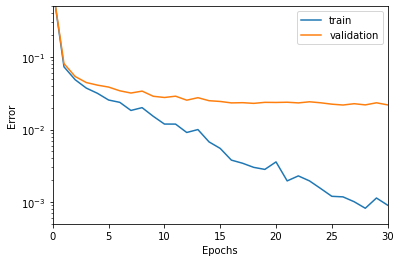

result after 15 epochs, train: cost 0.02620, error 0.00586 ; validation: cost 0.08273, error 0.02445
result after 30 epochs, train: cost 0.01126, error 0.00097 ; validation: cost 0.07528, error 0.02252


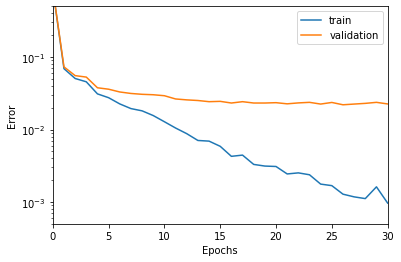

result after 15 epochs, train: cost 0.02864, error 0.00714 ; validation: cost 0.08455, error 0.02597
result after 30 epochs, train: cost 0.01130, error 0.00101 ; validation: cost 0.07706, error 0.02218


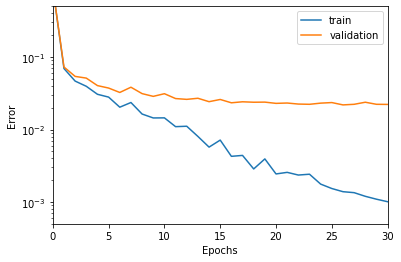

result after 15 epochs, train: cost 0.03000, error 0.00695 ; validation: cost 0.07913, error 0.02437
result after 30 epochs, train: cost 0.01095, error 0.00086 ; validation: cost 0.06858, error 0.02134


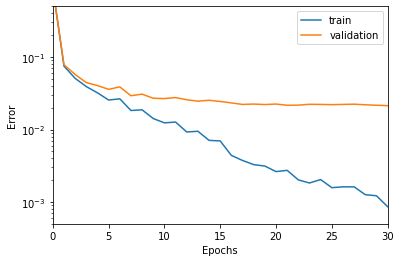

result after 15 epochs, train: cost 0.02528, error 0.00506 ; validation: cost 0.07720, error 0.02294
result after 30 epochs, train: cost 0.01137, error 0.00095 ; validation: cost 0.07488, error 0.02134


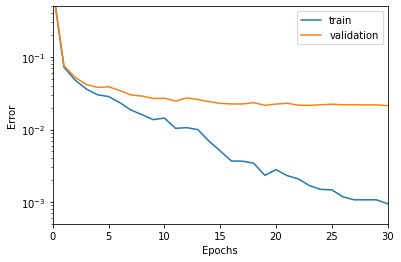

In [17]:
#implement k-fold cross validation

#choose k-fold 
k_fold = 5

### START YOUR CODE ###

# ....

### STOP YOUR CODE ###

In [18]:
print('mean validation error: %.7r , variance: %.7r' %(np.mean(results_k_fold[:,4]) , np.std(results_k_fold[:,4])))

mean validation error: 0.02184 , variance: 0.00046


### Describe your Findings for Exercise 3

By running the training with different settings for learning rate, number of epochs, batch size explore which combination is best suited to obtain good test performance. .

Specify your choice of these hyper-parameters and justify why you consider your choice best suited.

Finally estimate the variance, i.e. the generalisation error through 5-fold cross validation.

#### YOUR FINDINGS ...



...



...

(254, 784)
[[5 2 7 0 2 1 8 5 2 6 8 0 3 3 2]
 [9 9 8 7 7 5 9 0 5 3 4 3 6 3 5]
 [5 8 5 5 7 3 2 1 8 2 5 5 3 7 9]
 [6 1 4 5 3 1 5 9 2 9 7 3 8 5 5]
 [3 5 5 9 9 5 2 7 1 9 3 2 9 1 4]
 [3 7 4 9 7 9 9 8 2 9 2 9 9 2 4]
 [4 9 5 9 0 1 6 5 7 6 5 3 8 0 0]
 [3 2 2 3 5 5 2 3 3 5 0 4 3 8 5]
 [8 7 5 8 9 9 0 9 4 2 2 4 6 0 5]
 [3 9 9 5 0 2 3 7 9 1 3 4 9 9 4]
 [7 8 1 9 9 0 6 9 5 3 8 4 4 9 2]
 [2 5 6 3 7 8 4 5 3 3 8 9 5 9 3]
 [3 7 5 9 5 9 3 3 6 2 4 2 3 2 4]
 [8 1 7 8 9 5 9 6 3 0 1 3 9 2 0]
 [9 5 3 9 8 8 5 0 5 8 4 2 3 7 3]]


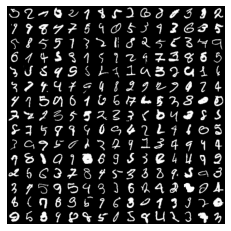

In [19]:
#analyse false classified images

#switch to see training errors
if False:
    y_pred = mlp.y_pred[0]
    x_data = mlp.data['x_train']
    y_data = mlp.data['y_train']
else:
    y_pred = mlp.y_pred[1]
    x_data = mlp.data['x_val']
    y_data = mlp.data['y_val']


#choose here the number of digits shown, a full image of rows x cols tiles of digits is created
rows = 15
cols = 15
#figure size can be set
fig_size = [4,4]


yhat = np.argmax(y_pred, axis=1)
indices = np.where(yhat != y_data)[0]

false_classifications = x_data[indices,:]

print(false_classifications.shape)

plot_tiles(false_classifications, rows, cols, img_width, fig_size)


#print the correct labels 
correct_labels = y_data[indices]

if correct_labels.shape[0] < rows*cols:
    correct_labels = np.append(correct_labels, -np.ones((rows*cols-correct_labels.shape[0])))
    
correct_labels = correct_labels[:rows*cols].reshape(cols,rows).T

print(np.array(correct_labels, dtype = int))

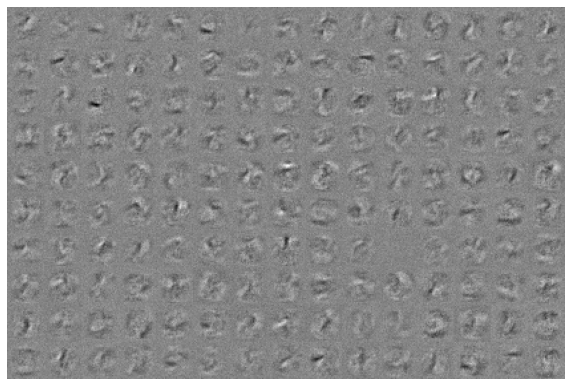

In [20]:
#visualise the weights of the first layer, order is:
#0 r+1 .... r*(c-1)+1
#1 r+2 .... r*(c-1)+2
#................
#r 2r  .... r*c

rows = 10
cols = 15
#figure size can be set
fig_size = [10,10]

plot_tiles(mlp.layers[0].W.T, rows, cols, img_width, fig_size)

# Tests
### Test analytical value of derivative using backpropagation through comparison with difference quotient¶


In [21]:
#define set of m dummy samples with num_features features each being N(0,1) normalised
num_features = 50
m = 3
num_outcomes = 4
x_0 = np.random.randn(m, num_features)
y_0 = np.random.randint(0,num_outcomes,size=m)

#create a dummy MLP; num of input and output layers is fixed, hidden layers can be configured
mlp_0 = MultiLayerPerceptron([num_features, 50, 40, 30,num_outcomes])

#do propagation and backpropagation
y_pred = mlp_0.propagate(x_0)
dL_x = mlp_0.back_propagate(y_0)

L = mlp_0.cost_funct(y_pred, y_0)

#apply eps to given layer
eps = 1.0e-8
#maximum allowed difference
max_diff = 4.0e-7

#loop over all layers
layer_ind = 0
for layer in mlp_0.layers:
    print('test weights W for layer %r' % layer_ind)
    #loop over all weights in layer
    for i0 in range(layer.W.shape[0]):
        for i1 in range(layer.W.shape[1]):
            #add eps to weight
            layer.W[i0,i1] += eps
            #do propagation
            y_pred = mlp_0.propagate(x_0)
            #determine new cost function and ...
            L_eps = mlp_0.cost_funct(y_pred, y_0)
            #determine approx. derivative
            dL = (L_eps-L)/eps

            #compare this value to result from backpropagation
            if np.abs(dL - layer.dL_dW[i0,i1]) > max_diff:
                print('layer = %r, i0 = %r, i1 = %r, diff = %r' %(layer_ind, i0, i1, dL-layer.dL_dW[i0,i1]))

            #set value back to original value
            layer.W[i0,i1] -= eps

    print('test bias B for layer %r' % layer_ind)
    
    ### START YOUR CODE ###

    # ....

    ### STOP YOUR CODE ###
            
    layer_ind += 1

test weights W for layer 0
test bias B for layer 0
test weights W for layer 1
test bias B for layer 1
test weights W for layer 2
test bias B for layer 2
test weights W for layer 3
test bias B for layer 3


# Unit Tests
### Unit Test for DenseLayer propagate¶

In [22]:
x_0 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,0.1,-0.3, 0.2,-1.0]).reshape(4,3)


#set seed to have reproducible weight and bias values
np.random.seed(1)
denseLayer = DenseLayer(3,10)

#do propagation
y_pred = denseLayer.propagate(x_0)

#compare with expected result
y_exp = np.array([[0.52387181, 0.40396787, 0.40673666, 0.39516787, 0.44870316,
        0.46325643, 0.44800045, 0.52250828, 0.64177606, 0.54377411],
       [0.65184139, 0.26376729, 0.33724394, 0.34890365, 0.43158856,
        0.46702823, 0.44965501, 0.55213273, 0.65999146, 0.53030523],
       [0.77477231, 0.1776142 , 0.35920889, 0.29020704, 0.6962619 ,
        0.17069921, 0.55595931, 0.31483054, 0.66023506, 0.62258729],
       [0.53408132, 0.33982198, 0.36956609, 0.40896545, 0.35927701,
        0.61033343, 0.37192652, 0.6134586 , 0.64467654, 0.525402  ]]
)
np.testing.assert_array_almost_equal(y_pred,y_exp,decimal=8)

### Unit Test for DenseLayer back_propagate
Assumes that Unit Test for propagate is correct¶

In [23]:
x_0 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,0.1,-0.3, 0.2,-1.0]).reshape(4,3)


#set seed to have reproducible weight and bias values
np.random.seed(1)
denseLayer = DenseLayer(3,10)

#do propagation
y_pred = denseLayer.propagate(x_0)
dL_da = denseLayer.back_propagate(y_pred)

dL_da_exp = np.array([[-0.02431088, -0.04973171,  0.00828529],
       [ 0.00498509, -0.00298277, -0.0359108 ],
       [ 0.14366991,  0.09539264,  0.02318067],
       [-0.0743301 , -0.06057902, -0.02875787]])

dL_dW_exp = np.array([[ 0.03776203,  0.00819259,  0.02288887,  0.01621628,  0.04145237,
         0.00672648,  0.03889928,  0.01941287,  0.04073352,  0.04009638],
       [ 0.0791024 ,  0.02237512,  0.04718678,  0.03962846,  0.07536214,
         0.03373019,  0.07249135,  0.05306632,  0.08512549,  0.08129332],
       [-0.07662816, -0.03851108, -0.04566434, -0.05011735, -0.05178891,
        -0.07338575, -0.05441669, -0.07857942, -0.0813079 , -0.07223553]])

dL_dB_exp = np.array([[0.13667473, 0.06266722, 0.08557748, 0.08308514, 0.1117058 ,
        0.10018896, 0.11154816, 0.12006886, 0.14785754, 0.13607328]])

np.testing.assert_array_almost_equal(dL_da,dL_da_exp,decimal=8)
np.testing.assert_array_almost_equal(denseLayer.dL_dW,dL_dW_exp,decimal=8)
np.testing.assert_array_almost_equal(denseLayer.dL_dB,dL_dB_exp,decimal=8)

### Unit Test for SoftmaxLayer propagate¶

In [24]:
x_0 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,0.1,-0.3, 0.2,-1.0]).reshape(4,3)


#set seed to have reproducible weight and bias values
np.random.seed(1)
softMaxLayer = SoftmaxLayer(3,10)

#do propagation
y_pred = softMaxLayer.propagate(x_0)

#compare with expected result
y_exp = np.array([[0.11362611, 0.06999293, 0.07080156, 0.06747203, 0.0840525 ,
        0.08913158, 0.08381403, 0.11300674, 0.18501456, 0.12308797],
       [0.18665063, 0.03571663, 0.05072886, 0.05342259, 0.0756958 ,
        0.08735819, 0.08145338, 0.12290197, 0.19351435, 0.11255761],
       [0.27679327, 0.01737822, 0.04510595, 0.03289875, 0.18444911,
        0.01656238, 0.10074499, 0.03697278, 0.15635912, 0.13273545],
       [0.11274874, 0.05062964, 0.05765898, 0.06805941, 0.05515356,
        0.15405948, 0.05824533, 0.15610028, 0.17845652, 0.10888806]]
)
np.testing.assert_array_almost_equal(y_pred,y_exp,decimal=8)

### Unit Test for SoftmaxLayer back_propagate
Assumes that Unit Test for propagate is correct¶

In [25]:
x_0 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,0.1,-0.3, 0.2,-1.0]).reshape(4,3)


#set seed to have reproducible weight and bias values
np.random.seed(1)
softMaxLayer = SoftmaxLayer(3,10)

#do propagation
y_pred = softMaxLayer.propagate(x_0)
y_0 = np.array([0, 4, 8, 7])
dL_da = softMaxLayer.back_propagate(y_0)

dL_da_exp = np.array([[-0.64178465, -0.59845119,  0.41885208],
       [-0.28299565, -0.40390096, -0.43205205],
       [ 0.1360029 ,  0.20574427,  0.06930959],
       [ 0.20224965,  0.27875041,  0.29687246]])

dL_dW_exp = np.array([[ 2.57559980e-02,  5.83280983e-03,  1.30285837e-02,
         9.16496383e-03, -3.68257130e-05,  1.41062101e-03,
         2.90812170e-02,  8.43311084e-02, -2.05368013e-01,
         3.67995366e-02],
       [ 1.10606893e-01,  1.52627166e-02,  2.79088254e-02,
         2.41046276e-02, -4.15106198e-02,  2.70619277e-02,
         5.29686590e-02, -1.01422806e-02, -2.78627845e-01,
         7.23670961e-02],
       [-1.45197004e-03, -2.64015821e-02, -3.12794292e-02,
        -3.46084327e-02,  2.15594950e-01, -6.66252266e-02,
        -3.86921043e-02,  1.72698253e-01, -1.27959830e-01,
        -6.12746280e-02]])

dL_dB_exp = np.array([[-0.07754531,  0.04342935,  0.05607384,  0.0554632 , -0.15016226,
         0.08677791,  0.08106443, -0.14275456, -0.07166386,  0.11931727]])

np.testing.assert_array_almost_equal(dL_da,dL_da_exp,decimal=8)
np.testing.assert_array_almost_equal(softMaxLayer.dL_dW,dL_dW_exp,decimal=8)
np.testing.assert_array_almost_equal(softMaxLayer.dL_dB,dL_dB_exp,decimal=8)
